In [2]:
from pathlib import Path
import pandas as pd
import os
from scipy.stats import pearsonr, kstest
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

     |████████████████████████████████| 185 kB 35.2 MB/s 
     |████████████████████████████████| 9.8 MB 58.9 MB/s 


In [ ]:
#@title Load Data. 
#@markdown Select `load_from_online` if downloading results from Organisciak et al (2022).
load_from_online = True #@param {type: 'boolean'}
if load_from_online:
    !wget -O evaluation.zip https://github.com/massivetexts/llm_aut_study/blob/main/results/evaluation.zip?raw=true
    !unzip -o evaluation.zip
    evaldir = Path('evaluation')
else:
    # path to evaluation files
    evaldir = Path('drive/MyDrive/Grants/MOTES/Data/evaluation')

In [15]:
#@title Process Data
#@markdown Run this cell to run data preprocessing.
paths = list(evaldir.glob('*/*csv'))
dfs = []
for path in paths:
    if path.parent.stem not in ['gt_main2', 'all', 'gt_byprompt', 'fewshot']:
        continue
    df = pd.read_csv(path, index_col=0)
    df = df[[col for col in ['id', 'model', 'participant', 'prompt', 'target', 'predicted', 'src', 'proportion', 'nexamples', 'ncompletions', 'total_tokens'] if col in df.columns]]
    df['split'] = path.parent.stem
    dfs.append(df)
df = pd.concat(dfs)
if 'proportion' not in df.columns:
    df['proportion'] = 1
else:
    df.proportion = df.proportion.fillna(1)
def normalize_model_name(x):
    x = x.lower()
    x = x.replace('_', '-')
    x = x.replace('-text-similarity', '')
    x = x.replace('gpt-', 'gpt3_')
    x = x.replace('-001', '')
    return x
df.model = df.model.apply(normalize_model_name)
df.sample()

,id,model,participant,prompt,target,predicted,src,split,proportion,total_tokens,nexamples,ncompletions
2186,dod20_bottle-2c83,semdis-glove-nf-m,dod2052,bottle,1.3,0.76615,dod20,gt_main2,1.0,NaN,NaN,NaN


In [16]:
# additional versions of baselines that I crunched, but are excessive to include
drop_models = ['semdis-tasa-nf-m', 'semdis-cbowbncwikiukwac-nf-m', 'semdis-cbowsubtitle-nf-m', 
               'semdis-cbowukwacsubtitle-nf-m', 
               'semdis-glove-nf-m', 'ocs-stop', 'ocs-weight', 'ocs-target']

model_order = ['semdis-mean', 'semdis-tasa-nf-m', 'semdis-cbowbncwikiukwac-nf-m', 
               'semdis-cbowsubtitle-nf-m', 'semdis-cbowukwacsubtitle-nf-m', 
               'semdis-glove-nf-m', 'ocs-main', 'ocs-weight', 'ocs-stop',
               'ocs-target', 'st5-base', 'st5-large', 'st5-3b', 'gpt3_emb-ada',
               'gpt3_emb-babbage', 't5-base', 'gpt3-finetune-ada', 'gpt3-ada',
               'gpt3-finetune-babbage', 'gpt3-babbage',
               'gpt3-curie', 'gpt3-davinci']
remaining = [x for x in set(df.model.unique()).difference(model_order)]
model_order += remaining

## Performance on main dataset

In [17]:
split = 'gt_main2'
print(split.upper().center(69,'-'))
x = df[(df.split == split) & (df.proportion == 1)]
all = x.groupby('model').corr().loc[(slice(None), 'target'), 'predicted'].reset_index()[['model','predicted']].rename(columns={'predicted': 'ALL'}).set_index('model')
y = x.groupby(['model', 'src']).corr().loc[(slice(None), slice(None), 'target'), 'predicted'].reset_index()
z = y.pivot(index='model', columns='src', values='predicted')
all = all.merge(z, left_index=True, right_index=True)
all = all.loc[[m for m in model_order if m in all.index]]

all = all.reset_index()
all[['class', 'subclass']] = all.model.str.split('-', 1, expand=True).values
def categorize(model):
    model = model.lower()
    if model in ['semdis', 'ocs']:
        return 'baseline'
    elif model in ['st5', 'gpt3_emb']:
        return 'LLM embed'
    elif model in ['t5', 'gpt3']:
        return 'LLM fine-tune'
    else:
        'unknown'
all['category'] = all['class'].apply(categorize, 1)

def make_pretty(styler, include_gradient=True, gradient_range=(0,1), precision=3):
    styler.set_caption("Performance")
    #styler.format_index(lambda v: v.strftime("%A"))
    styler.format(precision=precision)
    if include_gradient:
        styler.background_gradient(axis=None, vmin=gradient_range[0], vmax=gradient_range[1], cmap="YlGnBu")
    styler.highlight_max(props='font-weight:bold;', axis = 0)
    return styler
forpaper = all[~all.model.isin(drop_models)].set_index(['category', 'model']).drop(columns=['class','subclass'])
forpaper.style.pipe(lambda x: make_pretty(x, gradient_range=(forpaper.min().min(), forpaper.max().max())))

-------------------------------GT_MAIN2------------------------------


In [18]:
forpaper = all[~all.model.isin(drop_models)].groupby('category').mean().loc[['baseline', 'LLM embed', 'LLM fine-tune']]
forpaper.style.pipe(lambda x: make_pretty(x, gradient_range=(forpaper.min().min(), forpaper.max().max()), precision=3))

,ALL,betal18,bs12,dod20,hmsl,motesf,motesp,setal08,snb17,snbmo09
category,,,,,,,,,,
baseline,0.188,0.265,0.172,0.307,0.259,0.224,0.146,0.196,0.175,0.137
LLM embed,0.222,0.395,0.241,0.393,0.303,0.249,0.420,0.259,0.316,0.231
LLM fine-tune,0.783,0.689,0.647,0.754,0.726,0.722,0.633,0.684,0.640,0.710


Skew: 0.5148773466684663


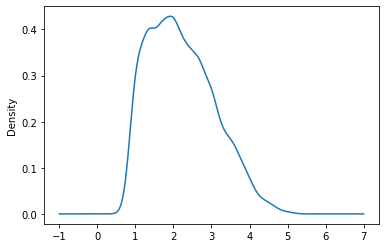

In [19]:
#@title Do the models over or under-estimate the results?
#@markdown Look at distribution. For example, the ocs-main distribution and skew:
x[x.model=='ocs-main'].target.plot(kind='kde')
print("Skew:", x[x.model=='ocs-main'].target.skew())

In [20]:
#@markdown Skew for all models
x[~x.model.isin(drop_models)].groupby('model').predicted.skew().sort_values()

model
semdis-mean        -1.747287
ocs-main           -0.504262
gpt3_emb-babbage   -0.488987
st5-large          -0.417643
st5-3b             -0.391320
st5-base           -0.348605
gpt3_emb-ada        0.191922
gpt3-babbage        0.445391
gpt3-ada            0.446683
gpt3-davinci        0.464987
gpt3-curie          0.491150
t5-base             0.555749
Name: predicted, dtype: float64

gt skew 0.51


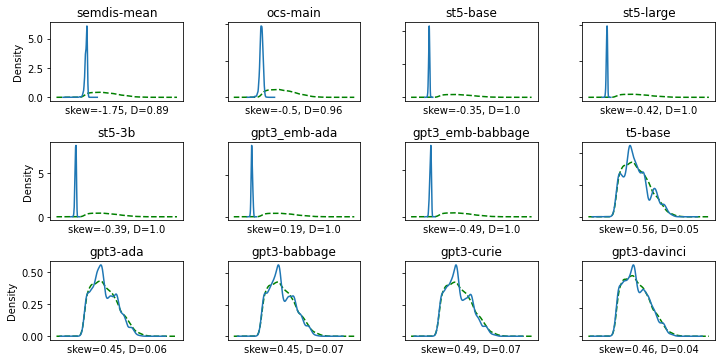

In [21]:
#@markdown Plot distributions
x = df[(df.split == split) & (df.proportion == 1) & ~df.model.isin(drop_models)]
rows = 3
cols = len(x.model.unique())//rows
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(10,5))
fig.tight_layout(h_pad=2)
gt = x[x.model=='ocs-main'].target # the *target* distribution, not predicted
print('gt skew', gt.skew().round(2))
for i, model in enumerate([m for m in model_order if m in x.model.unique()]):
    ax = axs[(i)//cols, (i)%cols]
    z = x[x.model == model]
    ksstat = kstest(gt, z.predicted) #Kolmogorov-Smirnov Goodness-of-Fit Test
    gt.plot(kind='kde', ax=ax, color='green', linestyle='--')
    z.predicted.plot(kind='kde', ax=ax, title=model)
    ax.label_outer()
    ax.set_xticks([])
    ax.set_xlabel(f'skew={z.predicted.skew().round(2)}, D={np.round(ksstat.statistic, 2)}')
#fig.delaxes(axs[1, cols-1])

In [23]:
def get_sig(x):
    return pearsonr(x['target'], x['predicted'])[1]

no_na = x[~x[['target', 'predicted']].isna().any(1)]
allp = no_na.groupby(['model']).apply(get_sig).sort_values().reset_index().rename(columns={0: 'ALL'}).set_index('model')
yp = no_na.groupby(['model', 'src']).apply(get_sig).reset_index()
zp = yp.pivot(index='model', columns='src', values=0)
allp = allp.merge(zp, left_index=True, right_index=True)
allp = allp.loc[[m for m in model_order if m in allp.index and m not in drop_models]]
print("Statistical significance, marked only for non-significant results")
allp.round(2).replace(0, '')

Statistical significance, marked only for non-significant results


,ALL,betal18,bs12,dod20,hmsl,motesf,motesp,setal08,snb17,snbmo09
model,,,,,,,,,,
semdis-mean,,,0.01,,,,0.77,0.2,0.02,0.68
ocs-main,,,0.01,,,,0.02,,,
st5-base,,,,,,,,,,
st5-large,,,,,,,0.01,,,
st5-3b,,,,,,,,,,
gpt3_emb-ada,,,,,,,,,,
gpt3_emb-babbage,,,,,,,0.02,,,
t5-base,,,,,,,,,,
gpt3-ada,,,,,,,,,,


In [24]:
#@title By Prompt
#@markdown Which prompts are easier/tougher to score?
x = df[(df.split == 'gt_main2') & (df.proportion == 1)].copy()
#print('temporary - fixing cat names, but should re-run eval and remove this code at the end'.upper())
#x.prompt = x.prompt.str.replace('hat cap', 'hat').str.replace('lead pencil', 'pencil').str.replace('light bulb', 'lightbulb').str.replace('lightbulbs', 'lightbulb').str.replace('spoons', 'spoon').str.replace('soccer ball', 'ball')
#all = x.groupby('model').corr().loc[(slice(None), 'target'), 'predicted'].reset_index()[['model','predicted']].rename(columns={'predicted': 'ALL'}).set_index('model')
y = x.groupby(['model', 'prompt']).corr().loc[(slice(None), slice(None), 'target'), 'predicted'].reset_index()
z = y.pivot(index='model', columns='prompt', values='predicted')
#all = all.merge(z, left_index=True, right_index=True).round(3)
z['M'] = z.mean(1)
z['SD'] = z.std(1)
z = z.round(3).loc[[col for col in model_order if col in z.index and col not in drop_models]]
#display(z)
#plt.figure(figsize=(15,8))
#ax = sns.heatmap(z, annot=True, vmin=0, cbar=False, cmap="Blues")
#ax.xaxis.tick_top()
z = z.reset_index()
z[['class', 'subclass']] = z.model.str.split('-', 1, expand=True).values
z['category'] = z['class'].apply(categorize, 1)
forpaper = z[~z.model.isin(drop_models)].set_index(['category', 'model']).drop(columns=['class','subclass'])
forpaper.style.pipe(lambda x: make_pretty(x, gradient_range=(forpaper.min().min(), forpaper.max().max()), precision=2))

In [25]:
forpaper = z[~z.model.isin(drop_models)].groupby('category').mean().loc[['baseline', 'LLM embed', 'LLM fine-tune']]
forpaper.style.pipe(lambda x: make_pretty(x, gradient_range=(forpaper.min().min(), forpaper.max().max()), precision=2))

prompt,backpack,ball,book,bottle,box,brick,fork,hat,knife,lightbulb,pants,paperclip,pencil,rope,shoe,shovel,sock,spoon,table,tire,toothbrush,M,SD
category,,,,,,,,,,,,,,,,,,,,,,,
baseline,0.10,0.23,0.33,0.28,0.17,0.21,0.22,0.35,0.15,0.10,0.38,0.21,0.31,0.20,0.20,0.22,0.19,0.21,0.41,0.48,0.21,0.25,0.12
LLM embed,0.40,0.48,0.34,0.38,0.32,0.24,0.41,0.19,0.32,0.19,0.44,0.35,0.35,0.32,0.60,0.41,0.37,0.13,0.32,0.34,0.45,0.35,0.12
LLM fine-tune,0.51,0.79,0.73,0.85,0.68,0.62,0.74,0.64,0.77,0.71,0.87,0.76,0.80,0.50,0.81,0.78,0.63,0.64,0.86,0.86,0.76,0.73,0.12


In [26]:
x[['class', 'subclass']] = x.model.str.split('-', 1, expand=True).values
x['category'] = x['class'].apply(categorize, 1)
avg_ft = x.groupby(['category', 'model', 'prompt'])[['target','predicted']].corr()[['predicted']].iloc[::2].reset_index().groupby(['category', 'prompt'])[['predicted']].mean().loc['LLM fine-tune']
# entropy calculated when processing dataset
entropy = pd.Series({'backpack': 3.481, 'ball': 5.937, 'book': 6.135, 'bottle': 6.679, 'box': 7.901, 'brick': 8.483, 'fork': 5.946, 'hat': 5.914, 'knife': 7.627, 'lightbulb': 5.921, 'pants': 6.031, 'paperclip': 7.189, 'pencil': 5.915, 'rope': 7.574, 'shoe': 5.875, 'shovel': 5.759, 'sock': 5.916, 'spoon': 5.929, 'table': 6.051, 'tire': 5.959, 'toothbrush': 5.907}, name='entropy')
y = avg_ft.merge(entropy, left_index=True, right_index=True).sort_values('entropy') #.plot(kind='scatter', x='predicted', y='entropy')
print("Correlation of entropy with performance")
y.corr().round(3).values[0,1]

Correlation of entropy with performance


0.004

# Performance with different training sizes

Assuming n=16081 (hardcoded)


,model,gpt3-ada,gpt3-babbage
proportion,n,,
0.01,160,0.310473,0.482956
0.05,804,0.554208,0.610287
0.10,1608,0.667438,0.689459
0.20,3216,0.691564,0.726408
0.40,6432,0.729902,0.755257
0.60,9648,0.751006,0.771210
0.80,12864,0.755895,0.784700
1.00,16081,0.764006,0.791753


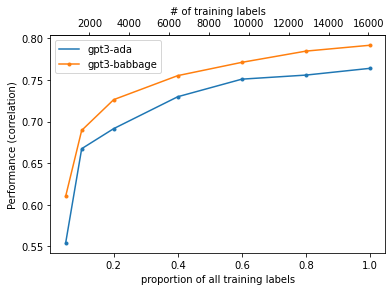

In [27]:
split = 'gt_main2'
totaln = 16081
print(f'Assuming n={totaln} (hardcoded)')
targetmodels = df[df.proportion < 1].model.unique().tolist()
x = df[(df.split == split) & (df.model.isin(targetmodels))]
all = x.groupby(['model', 'proportion']).corr().loc[(slice(None), slice(None), 'target'), 'predicted']
all = all.reset_index()[['model','proportion', 'predicted']].rename(columns={'predicted': 'corr'})
ax = None
for model in all[(all.proportion > 0.01) & (all.proportion < 1)].model.unique():
    ax = all[(all.model == model) & (all.proportion > 0.01)].plot(x='proportion', y='corr', ax=ax, label=model, style='.-')

# add top axis
def prop2n(prop):
    return totaln * prop

def n2prop(n):
    return n / totaln

ax.set_ylabel('Performance (correlation)')
ax.set_xlabel('proportion of all training labels')
secax = ax.secondary_xaxis('top', functions=(prop2n, n2prop))
secax.set_xlabel('# of training labels')
all['n'] = all.proportion.apply(prop2n, 0).astype(int)
all[all.proportion >= 0.01].pivot(index=['proportion', 'n'], columns='model', values='corr').dropna(axis=1)

In [28]:
x = all.pivot(index=['proportion', 'n'], columns='model', values='corr')
x['gpt3-ada'] / x['gpt3-babbage']

proportion  n    
0.01        160      0.642860
0.05        804      0.908109
0.10        1608     0.968060
0.20        3216     0.952032
0.40        6432     0.966429
0.60        9648     0.973803
0.80        12864    0.963291
1.00        16081    0.964955
dtype: float64

# Unseen Prompts

Look by Prompt.

# Few Shot

-------------------------------FEWSHOT-------------------------------


ALL  backpack   ball   book  bottle    box  brick  \
nexamples ncompletions                                                        
0.0       10.0          0.131    -0.373  0.248  0.009   0.228  0.224  0.103   
5.0       5.0           0.364    -0.222  0.634 -0.127   0.585  0.234  0.233   
          10.0          0.424     0.214  0.334  0.456   0.447  0.311  0.372   

                         fork    hat  knife  ...  paperclip  pencil   rope  \
nexamples ncompletions                       ...                             
0.0       10.0          0.271  0.431  0.119  ...      0.294   0.214  0.211   
5.0       5.0           0.379  0.462  0.176  ...      0.383   0.541  0.290   
          10.0          0.626  0.412  0.215  ...      0.342   0.676  0.069   

                         shoe  shovel   sock  spoon  table   tire  toothbrush  
nexamples ncompletions                                                         
0.0       10.0          0.161   0.003  0.079  0.195  0.056  0.126       0.274  
5.0       5.0           0.511   0.348  0.500  0.295  0.509  0.379       0.445  
          10.0          0.412   0.335  0.339  0.080  0.569  0.309       0.496  

[3 rows x 22 columns]

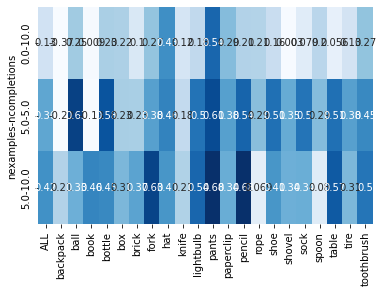

In [29]:
split = 'fewshot'
print(split.upper().center(69,'-'))
x = df[(df.split == split) & (df.proportion == 1)]
groupvars = ['nexamples', 'ncompletions']
all = x.groupby(groupvars).corr().loc[(slice(None), slice(None), 'target'), 'predicted'].reset_index()[groupvars+['predicted']].rename(columns={'predicted': 'ALL'}).set_index(groupvars)
y = x.groupby(groupvars+['prompt']).corr().loc[(slice(None), slice(None), slice(None), 'target'), 'predicted'].reset_index()
z = y.pivot(index=groupvars, columns='prompt', values='predicted')
all = all.merge(z, left_index=True, right_index=True).round(3)
#all = all.loc[[m for m in model_order if m in all.index]]
display(all)
plt.show(sns.heatmap(all, annot=True, vmin=0, cbar=False, cmap="Blues"))

# Costs for GPT-3

In [30]:
x = df[~df.total_tokens.isna() & (df.split == 'gt_main2') & (df.proportion == 1)]
costs = x.groupby('model')['total_tokens'].aggregate(['count', 'sum', 'mean'])
costs['price/1k'] = [0.0016, 0.0024, 0.012, 0.12]
costs['avg cost/item'] = costs['mean']/1000 * costs['price/1k']
costs

,count,sum,mean,price/1k,avg cost/item
model,,,,,
gpt3-ada,3030,55754.0,18.40066,0.0016,0.000029
gpt3-babbage,3030,55754.0,18.40066,0.0024,0.000044
gpt3-curie,3030,55754.0,18.40066,0.0120,0.000221
gpt3-davinci,3030,55754.0,18.40066,0.1200,0.002208


In [31]:
costs['total_cost'] = (costs['sum']/1000 * costs['price/1k']).round(2)
costs['responses/dollar'] = (1/costs['avg cost/item']).round(0).astype(int)
costs

,count,sum,mean,price/1k,avg cost/item,total_cost,responses/dollar
model,,,,,,,
gpt3-ada,3030,55754.0,18.40066,0.0016,0.000029,0.09,33966
gpt3-babbage,3030,55754.0,18.40066,0.0024,0.000044,0.13,22644
gpt3-curie,3030,55754.0,18.40066,0.0120,0.000221,0.67,4529
gpt3-davinci,3030,55754.0,18.40066,0.1200,0.002208,6.69,453


In [32]:
print(costs[['responses/dollar']].to_markdown())

| model        |   responses/dollar |
|:-------------|-------------------:|
| gpt3-ada     |              33966 |
| gpt3-babbage |              22644 |
| gpt3-curie   |               4529 |
| gpt3-davinci |                453 |


,ALL,bottle,pants,paperclip,shovel,spoon,M,SD
model,,,,,,,,
semdis-mean,0.139,0.239,0.200,0.140,0.146,0.213,0.188,0.039
ocs-main,0.283,0.455,0.273,0.195,0.443,0.232,0.319,0.108
t5-base,0.473,0.493,0.429,0.462,0.339,0.293,0.403,0.076
gpt3-ada,0.596,0.709,0.646,0.545,0.448,0.539,0.577,0.091
gpt3-babbage,0.630,0.776,0.689,0.557,0.668,0.515,0.641,0.094
gpt3-curie,0.631,0.758,0.689,0.540,0.718,0.582,0.657,0.083


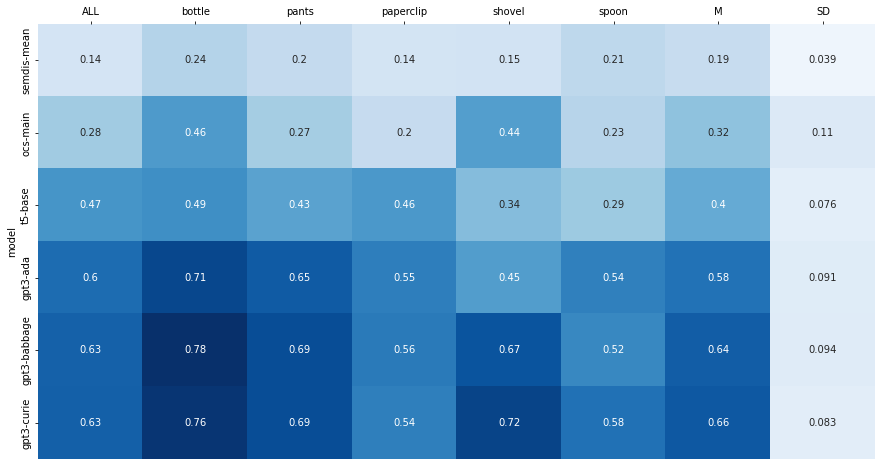

In [33]:
x = df[df.split == 'gt_byprompt'].copy()
all = x.groupby('model').corr().loc[(slice(None), 'target'), 'predicted'].reset_index()[['model','predicted']].rename(columns={'predicted': 'ALL'}).set_index('model')
y = x.groupby(['model', 'prompt']).corr().loc[(slice(None), slice(None), 'target'), 'predicted'].reset_index()
z = y.pivot(index='model', columns='prompt', values='predicted')
z['M'] = z.mean(1)
z['SD'] = z.std(1)
z = z.round(3)
all = all.merge(z, left_index=True, right_index=True).round(3).loc[[model for model in model_order if model in all.index]]
display(all[~all.index.isin(drop_models)])
plt.figure(figsize=(15,8))
ax = sns.heatmap(all[~all.index.isin(drop_models)], annot=True, vmin=0, cbar=False, cmap="Blues")
ax.xaxis.tick_top()

# Look at responses

Look at responses. This requires loading the ground truth.

This is most some curiosity-related stuff - inspecting qualitatively what the responses look like where the machine and judges agree.

In [36]:
base_dir = Path('drive/MyDrive/Grants/MOTES/Data/aut_ground_truth')
data_subdir = "gt_main2"
!cp {base_dir}/{data_subdir}.tar.gz .
!rm -rf data
!tar -xf {data_subdir}.tar.gz
data_dir = Path(f"data/{data_subdir}")
print("Data decompressed to", data_dir)

# load test data
testdata = pd.DataFrame([pd.read_json(x, orient='index')[0] for x in (data_dir / 'test').glob('*json')])
testdata.sample()

Data decompressed to data/gt_main2


,src,question,prompt,response,id,target,participant,response_num,count
0,motesf,What is a surprising use for a SOCK?,sock,it can be a mask,motesf_sock-09c3,3.6,motesf5ef0,3,NaN


Look at distribution of difference between model and human judges.

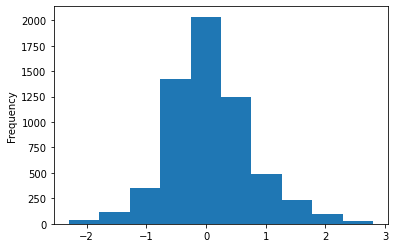

In [46]:
y = df[(df.split=='gt_main2') & (df.model=='gpt3-davinci')]
z = y.merge(testdata, on=['id'])
z['diff'] = z.target_x - z.predicted
z['diff'].plot(kind='hist')

Find some examples at different levels of creativity, where the model matched GT.

In [ ]:
z[(z['diff'] == 0) & (z['prompt_x'] == 'pants')].sort_values('predicted', ascending=False)[['prompt_x', 'response', 'predicted']].head(20)

,prompt_x,response,predicted
1259,pants,makeshift flag,4.0
1963,pants,make purse,3.5
403,pants,curtains,3.2
2772,pants,use as rope to tie stuff,3.0
2253,pants,to tie things with,2.5
2807,pants,decorate,2.5
2760,pants,modesty,1.2
101,pants,to cover lower body,1.0
490,pants,to wear them,1.0
1736,pants,wearing,1.0
